# Electrode State of Health

This notebook demonstrates some utilities to work with electrode State of Health (also sometimes called electrode stoichiometry), using the algorithm from Mohtat et al [1]

[1] Mohtat, P., Lee, S., Siegel, J. B., & Stefanopoulou, A. G. (2019). Towards better estimability of electrode-specific state of health: Decoding the cell expansion. Journal of Power Sources, 427, 101-111.

In [1]:
%pip install pybamm -q # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.


## Create and solve model

In [2]:
spm = pybamm.lithium_ion.SPM()
experiment = pybamm.Experiment([
    "Charge at 1C until 4.2V", 
    "Hold at 4.2V until C/50",
    "Discharge at 1C until 2.8V",
    "Hold at 2.8V until C/50",
])
parameter_values = pybamm.ParameterValues("Mohtat2020")

sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()
spm_sol.plot([
    "Voltage [V]", 
    "Current [A]", 
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
])

interactive(children=(FloatSlider(value=0.0, description='t', max=2.3248583539194754, step=0.02324858353919475…

## Solve for electrode SOH variables

Given a total amount of cyclable lithium capacity, $Q_{Li}$, electrode capacities, $Q_n$ and $Q_p$, and voltage limits, $V_{min}$ and $V_{max}$, we can solve for the min and max electrode SOCs, $x_0$, $x_{100}$, $y_0$, and $y_{100}$,  and the cell capacity, $C$, using the algorithm adapted from Mohtat et al [1].
First, we find $x_{100}$ and $y_{100}$ using
$$
\begin{align}
Q_{Li} &= y_{100}Q_p + x_{100}Q_n,
\\
V_{max} &= U_p(y_{100}) - U_n(x_{100}).
\end{align}
$$
Note that Mohtat et al use $n_{Li} = \frac{3600 Q_{Li}}{F}$ instead.
Then, we find $Q$ using
$$
\begin{align}
V_{min} &= U_p(y_{0}) - U_n(x_{0})
\\
&= U_p\left(y_{100} + \frac{Q}{Q_p}\right) - U_n\left(x_{100} - \frac{Q}{Q_n}\right)
\end{align}
$$
Finally, $x_0$ and $y_0$ are simply defined as
$$
\begin{align}
x_0 &= x_{100} - \frac{Q}{Q_n},
\\
y_0 &= y_{100} + \frac{Q}{Q_p}.
\end{align}
$$
We implement this in pybamm as an algebraic model.

In [3]:
param = pybamm.LithiumIonParameters()

Vmin = 2.8
Vmax = 4.2
Q_n = parameter_values.evaluate(param.n.Q_init)
Q_p = parameter_values.evaluate(param.p.Q_init)
Q_Li = parameter_values.evaluate(param.Q_Li_particles_init)

U_n = param.n.prim.U
U_p = param.p.prim.U
T_ref = param.T_ref

In [4]:
# First we solve for x_100 and y_100

model = pybamm.BaseModel()

x_100 = pybamm.Variable("x_100")
y_100 = (Q_Li - x_100 * Q_n) / Q_p

y_100_min = 1e-10

x_100_upper_limit = (Q_Li - y_100_min*Q_p)/Q_n

model.algebraic = {x_100: U_p(y_100, T_ref) - U_n(x_100, T_ref) - Vmax}
    
model.initial_conditions = {x_100: x_100_upper_limit}

model.variables = {
    "x_100": x_100,
    "y_100": y_100
}

sim = pybamm.Simulation(model, parameter_values=parameter_values)
sol = sim.solve([0])

x_100 = sol["x_100"].data[0]
y_100 = sol["y_100"].data[0]

for var in ["x_100", "y_100"]:
    print(var, ":", sol[var].data[0])

# Based on the calculated values for x_100 and y_100 we solve for x_0
model = pybamm.BaseModel()

x_0 = pybamm.Variable("x_0")
Q = Q_n * (x_100 - x_0)
y_0 = y_100 + Q/Q_p

model.algebraic = {x_0: U_p(y_0, T_ref) - U_n(x_0, T_ref) - Vmin}
model.initial_conditions = {x_0: 0.1}

model.variables = {
    "Q": Q,
    "x_0": x_0,
    "y_0": y_0,
}

sim = pybamm.Simulation(model, parameter_values=parameter_values)
sol = sim.solve([0])


for var in ["Q", "x_0", "y_0"]:
    print(var, ":", sol[var].data[0])

x_100 : 0.83337428922595
y_100 : 0.03354553395256055
Q : 4.968932758817601
x_0 : 0.0015118453536460625
y_0 : 0.8908948803914055


This is implemented in PyBaMM as the `ElectrodeSOHSolver` class

In [5]:
esoh_solver = pybamm.lithium_ion.ElectrodeSOHSolver(parameter_values, param)

inputs={ "V_min": Vmin, "V_max": Vmax, "Q_n": Q_n, "Q_p": Q_p, "Q_Li": Q_Li}

esoh_sol = esoh_solver.solve(inputs)

for var in ["x_100", "y_100", "Q", "x_0", "y_0"]:
    print(var, ":", esoh_sol[var])

x_100 : 0.833374276202919
y_100 : 0.03354554737459606
Q : 4.968932679279884
x_0 : 0.0015118456462390752
y_0 : 0.8908948800898482


## Check against simulations

Plotting the SPM simulations against the eSOH calculations validates the min/max stoichiometry calculations

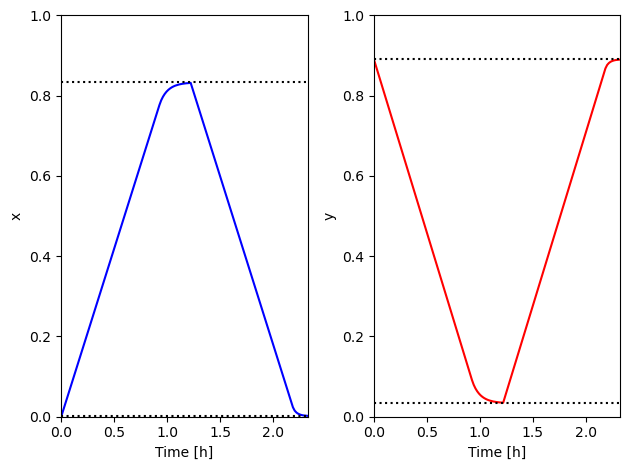

In [6]:
t = spm_sol["Time [h]"].data
x_spm = spm_sol["Negative electrode stoichiometry"].data
y_spm = spm_sol["Positive electrode stoichiometry"].data

x_0 = esoh_sol["x_0"].data * np.ones_like(t)
y_0 = esoh_sol["y_0"].data * np.ones_like(t)
x_100 = esoh_sol["x_100"].data * np.ones_like(t)
y_100 = esoh_sol["y_100"].data * np.ones_like(t)

fig, axes = plt.subplots(1,2)

axes[0].plot(t, x_spm, "b")
axes[0].plot(t, x_0, "k:")
axes[0].plot(t, x_100, "k:")
axes[0].set_ylabel("x")
    
axes[1].plot(t, y_spm, "r")
axes[1].plot(t, y_0, "k:")
axes[1].plot(t, y_100, "k:")
axes[1].set_ylabel("y")
    
for k in range(2):
    axes[k].set_xlim([t[0],t[-1]])
    axes[k].set_ylim([0,1])    
    axes[k].set_xlabel("Time [h]")
    
fig.tight_layout()


## How does electrode SOH depend on cyclable lithium

We can do a parameter sweep for the amount of cyclable lithium to see how it affects the electrode SOH parameters and cell capacity

In [7]:
all_parameter_sets = [
    k
    for k, v in pybamm.parameter_sets.items()
    if v["chemistry"] == "lithium_ion" and k not in ["Xu2019", "Chen2020_composite"]
]

def solve_esoh_sweep_QLi(parameter_set, param):
    parameter_values = pybamm.ParameterValues(parameter_set)

    Vmin = parameter_values["Lower voltage cut-off [V]"]
    Vmax = parameter_values["Upper voltage cut-off [V]"]
    Q_n = parameter_values.evaluate(param.n.Q_init)
    Q_p = parameter_values.evaluate(param.p.Q_init)
    
    Q = parameter_values.evaluate(param.Q/param.n_electrodes_parallel)
    esoh_solver = pybamm.lithium_ion.ElectrodeSOHSolver(parameter_values, param, known_value="cell capacity")
    inputs = {"V_max": Vmax, "V_min": Vmin, "Q": Q, "Q_n": Q_n, "Q_p": Q_p}
    sol_init_Q = esoh_solver.solve(inputs)
    
    Q_Li_init = parameter_values.evaluate(param.Q_Li_particles_init)
    esoh_solver = pybamm.lithium_ion.ElectrodeSOHSolver(parameter_values, param)
    inputs = {"V_max": Vmax, "V_min": Vmin, "Q_Li": Q_Li_init, "Q_n": Q_n, "Q_p": Q_p}
    sol_init_QLi = esoh_solver.solve(inputs)

    Q_Li_sweep = np.linspace(1e-6, Q_n + Q_p)
    sweep = {}
    variables = ["Q_Li", "x_0", "x_100", "y_0", "y_100", "Q"]
    for var in variables:
        sweep[var] = []

    for Q_Li in Q_Li_sweep:
        inputs["Q_Li"] = Q_Li
        try:
            sol = esoh_solver.solve(inputs)
            for var in variables:
                sweep[var].append(sol[var])
        except (ValueError, pybamm.SolverError):
            pass

    return sweep, sol_init_QLi, sol_init_Q
    
for parameter_set in ["Chen2020"]:
    sweep, sol_init_QLi, sol_init_Q = solve_esoh_sweep_QLi(parameter_set, param)


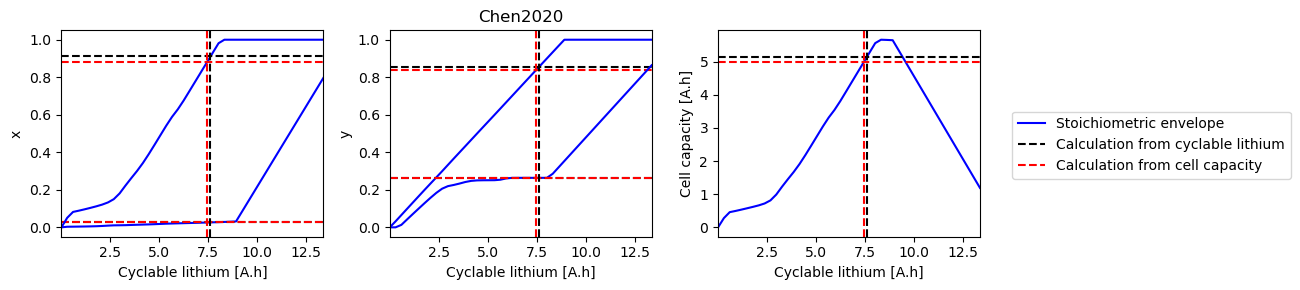

In [8]:

def plot_sweep(sweep, sol_init, sol_init_Q, parameter_set):
    fig, axes = plt.subplots(1,3,figsize=(10,3))
    parameter_values = pybamm.ParameterValues(parameter_set)
    Qn = parameter_values.evaluate(param.n.Q_init)
    Qp = parameter_values.evaluate(param.p.Q_init)
    # Plot min/max stoichimetric limits, including the value with the given Q_Li
    for i,ks in enumerate([["x_0","x_100"],["y_0","y_100"],["Q"]]):
        ax = axes.flat[i]
        for j,k in enumerate(ks):
            if i == 0 and j == 0:
                label1 = "Stoichiometric envelope"
                label2 = "Calculation from cyclable lithium"
                label3 = "Calculation from cell capacity"
            else:
                label1 = label2 = label3 = None
            ax.plot(sweep["Q_Li"], sweep[k],"b-", label=label1)
            ax.axhline(sol_init_QLi[k],c="k",linestyle="--", label=label2)
            ax.axhline(sol_init_Q[k],c="r",linestyle="--", label=label3)
        ax.set_xlabel("Cyclable lithium [A.h]")
        ax.set_ylabel(ks[0][0])
        ax.set_xlim([np.min(sweep["Q_Li"]),np.max(sweep["Q_Li"])])
        ax.axvline(sol_init_QLi["Q_Li"],c="k",linestyle="--")
        ax.axvline(sol_init_Q["Q_Li"],c="r",linestyle="--")
        # Plot capacities of electrodes
        # ax.axvline(Qn,c="b",linestyle="--")
        # ax.axvline(Qp,c="r",linestyle="--")
    axes[-1].set_ylabel("Cell capacity [A.h]")
    
    # Plot initial values of stoichometries
    sto_n_init = parameter_values.evaluate(param.n.prim.sto_init_av)
    sto_p_init = parameter_values.evaluate(param.p.prim.sto_init_av)
    # axes[0].axhline(sto_n_init,c="g",linestyle="--")
    # axes[1].axhline(sto_p_init,c="g",linestyle="--")

    axes[1].set_title(parameter_set)
    fig.legend(loc="center left", bbox_to_anchor=(1.01,0.5))
    fig.tight_layout()
    return fig, axes

plot_sweep(sweep, sol_init_QLi, sol_init_Q, "Chen2020");

Ai2020
Chen2020
Ecker2015
Marquis2019
Mohtat2020
NCA_Kim2011
OKane2022
ORegan2022
Prada2013
Ramadass2004


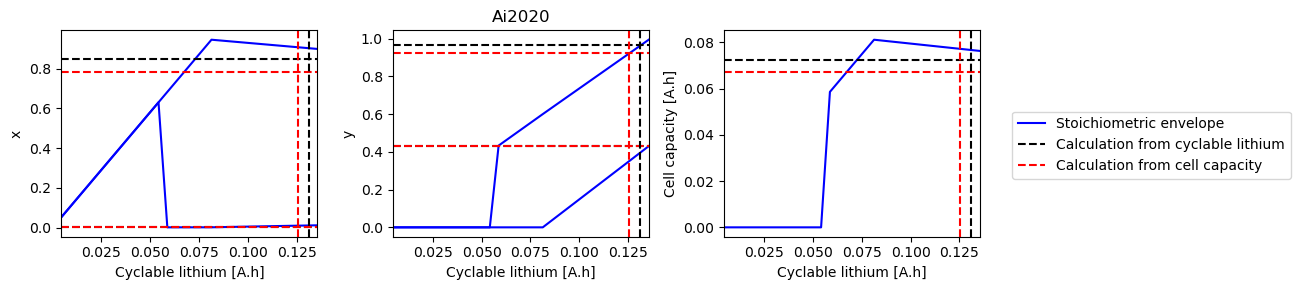

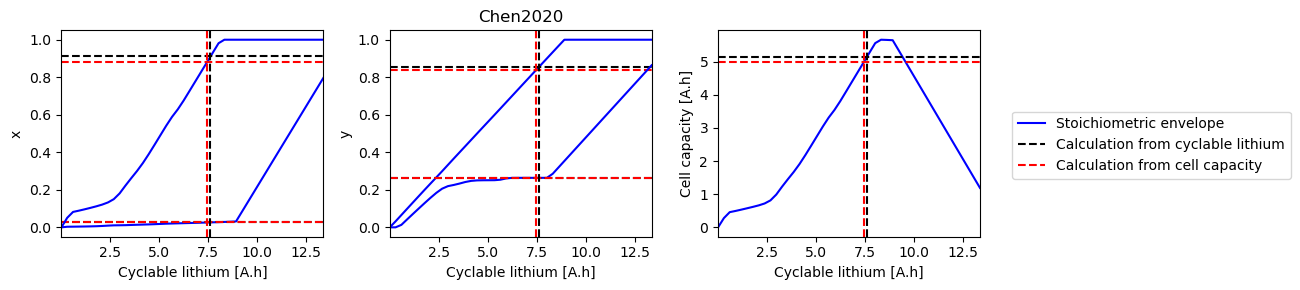

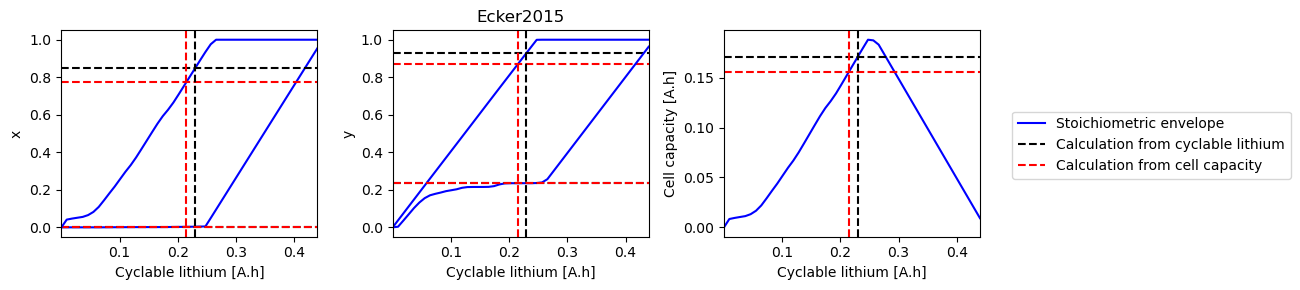

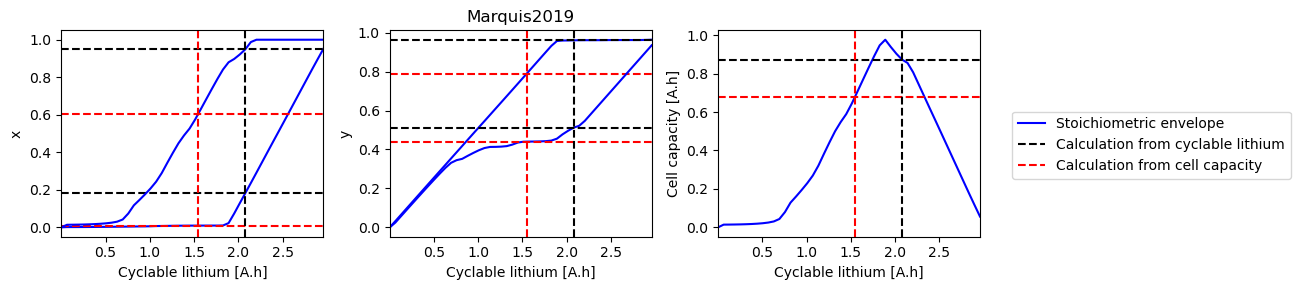

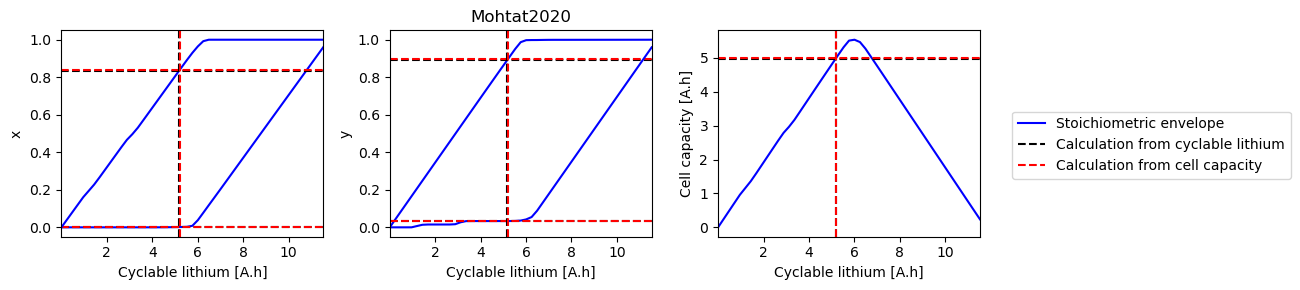

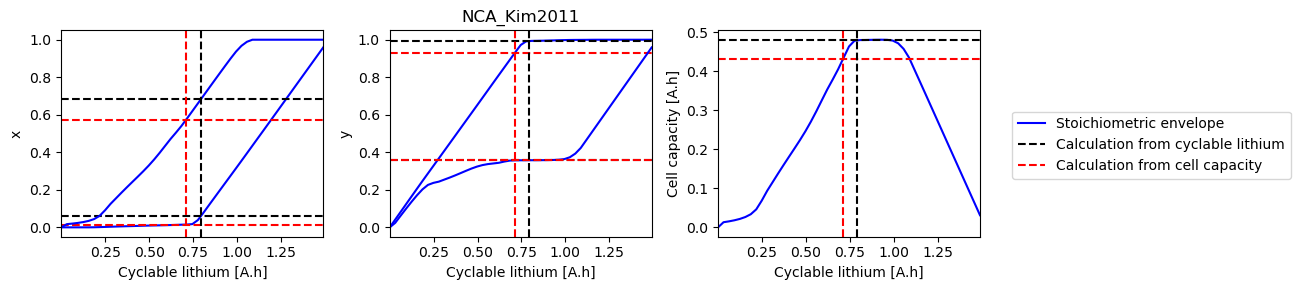

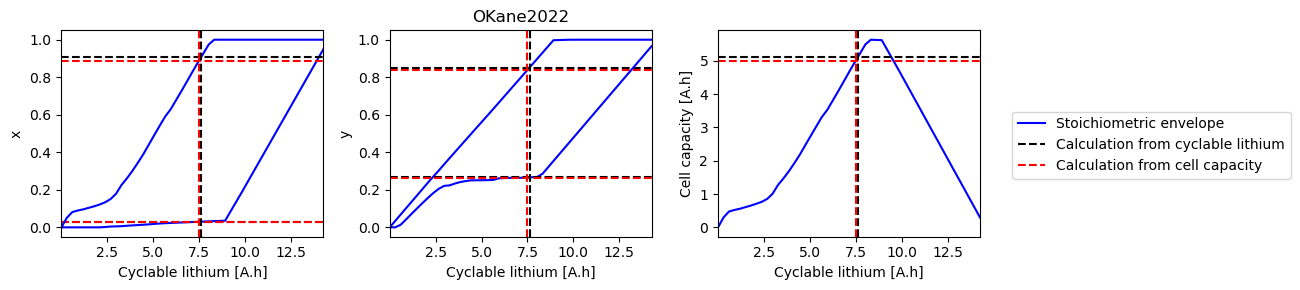

In [9]:
for parameter_set in all_parameter_sets:
    print(parameter_set)
    try:
        sweep, sol_init_QLi, sol_init_Q = solve_esoh_sweep_QLi(parameter_set, param)
        fig, axes = plot_sweep(sweep, sol_init_QLi, sol_init_Q, parameter_set)
    except ValueError:
        pass
    # print("success")


## References

The relevant papers for this notebook are:

In [10]:
pybamm.print_citations()

[1] Weilong Ai, Ludwig Kraft, Johannes Sturm, Andreas Jossen, and Billy Wu. Electrochemical thermal-mechanical modelling of stress inhomogeneity in lithium-ion pouch cells. Journal of The Electrochemical Society, 167(1):013512, 2019. doi:10.1149/2.0122001JES.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[4] Rutooj Deshpande, Mark Verbrugge, Yang-Tse Cheng, John Wang, and Ping Liu. Battery cycle life prediction with coupled chemical degradation and fatigue mechanics. Journal of